# Understanding the execution flow from `LightningQubit`

In [1]:
from typing import Iterable, Union
import quimb.tensor as qtn
import pennylane as qml
from pennylane.wires import Wires
import numpy as np

/home/pietropaolo.frisoni/anaconda3/envs/PennyLane/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Approach 1: choosing a tape

In [2]:
theta = 0.1
phi = 0.2

O1 = qml.Identity(wires=[0])
O2 = qml.PauliZ(wires=[1])

ops = [
    qml.DoubleExcitation(phi, wires=[12, 11, 0, 9]),
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.qml.CSWAP(wires=[0, 1, 2]),
    qml.Hadamard(wires=[4]),
    qml.qml.CSWAP(wires=[2, 3, 4]),
    qml.CNOT(wires=[2, 4]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
]

meas = [
    qml.expval(O2),
    qml.expval(O2),
    qml.var(qml.PauliY(wires=[2])),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[4])),
]


tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [3]:
tape.wires

<Wires = [12, 11, 0, 9, 7, 5, 1, 3, 4, 2]>

In [4]:
tape.operations

[DoubleExcitation(0.2, wires=[12, 11, 0, 9]),
 X(0),
 RX(0.1, wires=[0]),
 CSWAP(wires=[7, 0, 5]),
 RX(0.2, wires=[1]),
 CNOT(wires=[3, 4]),
 DoubleExcitation(0.2, wires=[1, 2, 3, 4]),
 CSWAP(wires=[0, 1, 2]),
 Hadamard(wires=[4]),
 CSWAP(wires=[2, 3, 4]),
 CNOT(wires=[2, 4]),
 DoubleExcitation(0.2, wires=[0, 1, 3, 4])]

In [5]:
tape.observables

[Z(1), Z(1), Y(2), I(0), Y(4)]

In [6]:
tape.measurements

[expval(Z(1)), expval(Z(1)), var(Y(2)), expval(I(0)), var(Y(4))]

In [7]:
tape.wires

<Wires = [12, 11, 0, 9, 7, 5, 1, 3, 4, 2]>

In [8]:
dev = qml.device("lightning.qubit", wires=tape.wires)

dev.execute(circuits=tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[12, 11, 0, 9, 7, 5, 1, 3, 4, 2], params=5>,)



(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Learning from `LightningQubit` using Python API

In [9]:
from pennylane_lightning.lightning_qubit import LightningQubit

In [67]:
obj = LightningQubit(wires=tape.wires)

In [68]:
obj.tracker

In [71]:
program, config = obj.preprocess()

In [73]:
program[0]

<validate_measurements([], {'name': 'lightning.qubit'})>

In [12]:
obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[12, 11, 0, 9, 7, 5, 1, 3, 4, 2], params=5>,)



(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Testing `LightningTensor` 

In [13]:
wires = tape.wires
backend = "quimb"
method = "mps"
c_dtype = np.complex128
max_bond_dim = None
cutoff = 0.0

In [14]:
from pennylane_lightning.lightning_tensor import LightningTensor

In [15]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)

In [16]:
obj._interface.state

MatrixProductState(tensors=10, indices=19, L=10, max_bond=2)

In [17]:
# obj._interface._circuitMPS.get_psi_reverse_lightcone(3)

In [18]:
type(obj._setup_execution_config())

pennylane.devices.execution_config.ExecutionConfig

In [63]:
program, config = obj.preprocess()

In [65]:
program[0]

<validate_measurements([], {'name': 'QuimbMPS interface'})>

In [66]:
config

ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'apply_reverse_lightcone': None, 'backend': 'quimb', 'c_dtype': <class 'numpy.complex128'>, 'cutoff': 0.0, 'method': 'mps', 'max_bond_dim': None, 'measure_algorithm': None, 'return_tn': False, 'rehearse': False}, interface=None, derivative_order=1)

In [22]:
# program[0]

In [23]:
# config

In [24]:
# config.device_options

In [25]:
obj.execute(circuits=tape)

(0.9999502079587207,
 0.9999502079587207,
 0.9901818584603503,
 0.9999999999999949,
 0.9999999999999951)

In [26]:
obj._interface._circuitMPS.gates

[<Gate(label=RAW133301236114800, params=raw, qubits=(2, 3))>,
 <Gate(label=RAW133301236114800, params=raw, qubits=(0, 2))>,
 <Gate(label=RAW133301950425776, params=raw, qubits=(3,))>,
 <Gate(label=RAW133301950425776, params=raw, qubits=(0,))>,
 <Gate(label=RAW133301236114800, params=raw, qubits=(2, 3))>,
 <Gate(label=RAW133301236114800, params=raw, qubits=(0, 1))>,
 <Gate(label=RAW133301235821520, params=raw, qubits=(1,))>,
 <Gate(label=RAW133301235818736, params=raw, qubits=(0,))>,
 <Gate(label=RAW133301236114800, params=raw, qubits=(0, 3))>,
 <Gate(label=RAW133301950425776, params=raw, qubits=(3,))>,
 <Gate(label=RAW133301236114800, params=raw, qubits=(3, 1))>,
 <Gate(label=RAW133301236115952, params=raw, qubits=(1,))>,
 <Gate(label=RAW133301236116144, params=raw, qubits=(0,))>,
 <Gate(label=RAW133301236114800, params=raw, qubits=(2, 1))>,
 <Gate(label=RAW133301236114800, params=raw, qubits=(2, 0))>,
 <Gate(label=RAW133301235414096, params=raw, qubits=(1,))>,
 <Gate(label=RAW13330123

In [27]:
obj._interface._circuitMPS.psi.tags

oset(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'PSI0', 'GATE_2', 'GATE_3', 'GATE_6', 'GATE_7', 'GATE_9', 'GATE_11', 'GATE_12', 'GATE_15', 'GATE_16', 'GATE_18', 'GATE_20', 'GATE_21', 'GATE_24', 'GATE_25', 'GATE_28', 'GATE_29', 'GATE_30', 'GATE_32', 'GATE_34', 'GATE_36', 'GATE_38', 'GATE_39', 'GATE_41', 'GATE_42', 'GATE_43', 'GATE_45', 'GATE_47', 'GATE_49', 'GATE_51', 'GATE_53', 'GATE_54', 'GATE_56', 'GATE_57', 'GATE_58', 'GATE_60', 'GATE_62', 'GATE_64', 'GATE_66', 'GATE_68', 'GATE_69', 'GATE_71', 'GATE_72', 'GATE_73', 'GATE_75', 'GATE_79', 'GATE_80', 'GATE_83', 'GATE_84', 'GATE_86', 'GATE_88', 'GATE_89', 'GATE_92', 'GATE_93', 'GATE_95', 'GATE_97', 'GATE_98', 'GATE_101', 'GATE_102', 'GATE_105', 'GATE_107', 'GATE_109', 'GATE_111', 'GATE_113', 'GATE_114', 'GATE_116', 'GATE_117', 'GATE_118', 'GATE_120', 'GATE_122', 'GATE_124', 'GATE_126', 'GATE_128', 'GATE_129', 'GATE_131', 'GATE_132', 'GATE_133', 'GATE_135', 'GATE_137', '

In [28]:
obj._interface.state

MatrixProductState(tensors=10, indices=19, L=10, max_bond=32)

In [29]:
obj._interface._circuitMPS.__dict__

{'_psi': MatrixProductState(tensors=10, indices=19, L=10, max_bond=32),
 'N': 10,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [<Gate(label=RAW133301236114800, params=raw, qubits=(2, 3))>,
  <Gate(label=RAW133301236114800, params=raw, qubits=(0, 2))>,
  <Gate(label=RAW133301950425776, params=raw, qubits=(3,))>,
  <Gate(label=RAW133301950425776, params=raw, qubits=(0,))>,
  <Gate(label=RAW133301236114800, params=raw, qubits=(2, 3))>,
  <Gate(label=RAW133301236114800, params=raw, qubits=(0, 1))>,
  <Gate(label=RAW133301235821520, params=raw, qubits=(1,))>,
  <Gate(label=RAW133301235818736, params=raw, qubits=(0,))>,
  <Gate(label=RAW133301236114800, params=raw, qubits=(0, 3))>,
  <Gate(label=RAW133301950425776, params=raw, qubits=(3,))>,
  <Gate(label=RAW133301236114800, params=raw, qubits=(3, 1))>,
  <Gate(label=RAW133301236115952, params=raw, qubits=(1,))>,
  <Gate(label=RAW133301236116144, params=raw, qubits=(0,))>,
  <Gate(label=RAW133301236114800

In [30]:
obj._interface._circuitMPS

<Circuit(n=10, num_gates=225, gate_opts={'contract': 'swap+split', 'propagate_tags': 'register'})>

In [31]:
obj._interface._circuitMPS.psi.max_bond()

32

In [32]:
obj._interface._circuitMPS.psi

MatrixProductState(tensors=10, indices=19, L=10, max_bond=32)

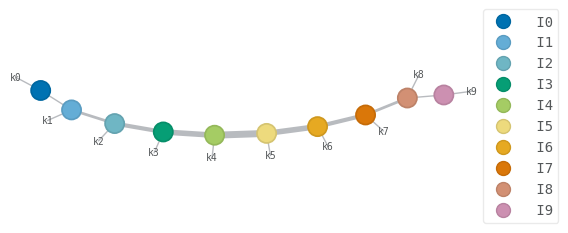

In [33]:
obj._interface.draw_state()

In [34]:
obj._interface._circuitMPS.psi.to_dense()

array([[ 2.87656541e-16-3.51640537e-02j],
       [-4.91947293e-16-3.19231147e-16j],
       [-6.98796420e-16-3.51640537e-02j],
       ...,
       [ 3.17165618e-18+4.00406344e-18j],
       [-3.35626407e-17+3.13200683e-17j],
       [-1.01539697e-17+3.68037979e-18j]])

In [35]:
# obj.compute_derivatives(tape)

In [36]:
# obj._interface.state_to_array()

In [37]:
obj._interface._circuitMPS._psi

MatrixProductState(tensors=10, indices=19, L=10, max_bond=32)

# Playing with `quimb`

In [38]:
wires = Wires(range(7))

init_state = qtn.MPS_computational_state(
    "0" * len(wires), tags=[str(l) for l in wires.labels]
)

qc = qtn.CircuitMPS(psi0=init_state)

op = qml.CNOT(wires=[0, 1])

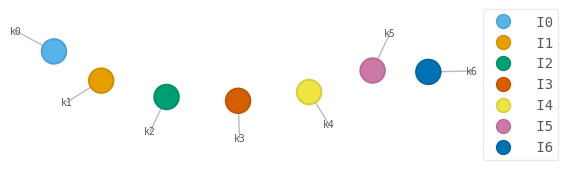

In [39]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)

In [40]:
init_state.gate_

functools.partial(<bound method gate_TN_1D of MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)>, inplace=True)

In [41]:
qc.amplitude("0111111")

0j

In [42]:
init_state

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [43]:
qc.ket_site_ind

<function str.format>

In [44]:
qc.__dict__

{'_psi': MatrixProductState(tensors=7, indices=7, L=7, max_bond=2),
 'N': 7,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': 0,
 '_storage': {('psi_simplified',
   'ADCRS',
   1e-12): MatrixProductState(tensors=7, indices=7, L=7, max_bond=2)},
 '_sampled_conditionals': {},
 '_marginal_storage_size': 0}

In [45]:
qc.gates

[]

In [46]:
gate = qtn.circuit.parse_to_gate(op.matrix(), tuple(op.wires))

In [47]:
gate

<Gate(label=RAW133301236114800, params=raw, qubits=((0, 1),))>

In [48]:
qtn.MPS_computational_state("0" * len(wires), tags=[str(l) for l in wires.labels])

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [49]:
qtn.MPS_zero_state(bond_dim=6, L=9)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

In [50]:
qtn.MPS_rand_state(L=9, bond_dim=6)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

# Question for the guy

In [51]:
import pennylane as qml
import quimb.tensor as qtn
import numpy as np

# case 1: single qubit gate (works fine)
op1 = qml.PauliX(wires=[0])
qtn.Circuit(N=1).apply_gate(
    op1.matrix().astype(np.complex128), *op1.wires, parametrize=None
)

# case 2: two qubit gate (works fine)
op2 = qml.CNOT(wires=[0, 1])
qtn.Circuit(N=2).apply_gate(
    op2.matrix().astype(np.complex128), *op2.wires, parametrize=None
)

# case 3: three qubit gate (fails)
op3 = qml.Toffoli(wires=[0, 1, 2])
# qtn.CircuitMPS(N=3).apply_gate(op3.matrix(), *op3.wires, parametrize=None)

# case 4: four qubit gate (fails)
op4 = qml.DoubleExcitation(0.1, wires=[0, 1, 2, 3])
# qtn.Circuit(N=4).apply_gate(op4.matrix().astype(np.complex128), *op4.wires, parametrize=None)

In [52]:
ops = [
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.CZ(wires=[4, 5]),
    qml.Hadamard(wires=[4]),
    qml.CCZ(wires=[0, 1, 2]),
    qml.CSWAP(wires=[2, 3, 4]),
    qml.QFT(wires=[0, 1, 2]),
    qml.CNOT(wires=[2, 4]),
    qml.Toffoli(wires=[0, 1, 2]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
]

meas = [
    qml.expval(O2),
    qml.expval(O2),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[2])),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[4])),
]


tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [53]:
obj = LightningQubit(wires=tape.wires)

obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 7, 5, 1, 3, 4, 2], params=4>,)



(0.10157883318982944, 0.10157883318982944, 1.0, 0.9881722793134764, 1.0, 1.0)

In [54]:
qml.Rot(0.2, -0.4, 0.3, wires=[2]).matrix()

array([[ 0.94959868-0.24247235j,  0.19842105-0.00992933j],
       [-0.19842105-0.00992933j,  0.94959868+0.24247235j]])

In [55]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.10157883318982242,
 0.10157883318982242,
 0.9999999999999614,
 0.988172279313441,
 0.9999999999999614,
 0.9999999999999611)

In [56]:
import pennylane as qml

# Define the operations
ops = [
    qml.Hadamard(wires=[0]),
    qml.CRX(0.5, wires=[1, 2]),
    qml.CNOT(wires=[0, 1]),
    qml.CRX(0.3, wires=[2, 3]),
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.CZ(wires=[4, 5]),
    qml.Hadamard(wires=[4]),
    qml.CCZ(wires=[0, 1, 2]),
    qml.CSWAP(wires=[2, 3, 4]),
    qml.QFT(wires=[0, 1, 2]),
    qml.CNOT(wires=[2, 4]),
    qml.Toffoli(wires=[0, 1, 2]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
    qml.CSWAP(wires=[1, 2, 3]),
    qml.RX(-0.8, wires=[0]),
    qml.CZ(wires=[0, 2]),
    qml.RY(0.4, wires=[1]),
    qml.CNOT(wires=[1, 3]),
    qml.CCZ(wires=[0, 1, 2]),
    qml.Hadamard(wires=[3])
]

# Define the measurement
meas = [
    qml.expval(qml.PauliX(wires=[0])),
    qml.var(qml.PauliY(wires=[1])),
    qml.expval(qml.PauliZ(wires=[2])),
    qml.expval(qml.PauliX(wires=[3]))
]

# Create the QuantumScript tape
tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [57]:
obj = LightningQubit(
    wires=tape.wires,
    c_dtype=c_dtype,
)


obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1, 2, 3, 7, 5, 4], params=8>,)



(0.2697347514992784,
 0.9022098454128101,
 0.4999999999999998,
 0.7500118092151864)

In [58]:
obj = LightningTensor(
    wires=tape.wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.2697347514992735,
 0.9022098454127945,
 0.4999999999999916,
 0.7500118092151746)

In [59]:
import pennylane as qml

# Define the operations
ops = [
    qml.Rot(-0.3, 0.7, -0.4, wires=[0]),
    qml.RY(0.8, wires=[1]),
    qml.CNOT(wires=[1, 2]),
    qml.CRX(0.2, wires=[0, 2]),
    qml.PauliY(wires=[1]),
    qml.CZ(wires=[0, 3]),
    qml.Hadamard(wires=[2]),
    qml.CSWAP(wires=[1, 2, 3]),
    qml.Rot(0.1, 0.5, 0.3, wires=[0]),
    qml.CRX(-0.6, wires=[2, 3]),
    qml.RX(0.4, wires=[1]),
    qml.CNOT(wires=[0, 1]),
    qml.Toffoli(wires=[0, 1, 3])
]

# Define the measurement
meas = [
    qml.var(qml.PauliX(wires=[0])),
    qml.expval(qml.PauliY(wires=[1])),
    qml.expval(qml.PauliZ(wires=[2])),
    qml.var(qml.PauliX(wires=[3]))
]

# Create the QuantumScript tape
tape = qml.tape.QuantumScript(ops=ops, measurements=meas)


In [60]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.8931039460927462,
 0.09691449955719136,
 0.8483533546735837,
 0.28366624188761835)

In [61]:
import pennylane as qml

# Define the operations
ops = [
    qml.Rot(0.1, -0.5, 0.6, wires=[0]),
    qml.RX(-0.2, wires=[1]),
    qml.CSWAP(wires=[0, 1, 2]),
    qml.RY(0.3, wires=[2]),
    qml.CNOT(wires=[1, 3]),
    qml.PauliX(wires=[2]),
    qml.CRX(0.4, wires=[0, 3]),
    qml.Hadamard(wires=[1]),
    qml.CCZ(wires=[0, 1, 3]),
    qml.CRX(0.7, wires=[2, 3]),
    qml.CZ(wires=[0, 1]),
    qml.Toffoli(wires=[0, 2, 3])
]

# Define the measurement
meas = [
    qml.expval(qml.PauliZ(wires=[0])),
    qml.var(qml.PauliY(wires=[1])),
    qml.expval(qml.PauliZ(wires=[2])),
    qml.var(qml.PauliX(wires=[3]))
]

# Create the QuantumScript tape
tape = qml.tape.QuantumScript(ops=ops, measurements=meas)


In [62]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.8775825618903625,
 0.9999999999999896,
 -0.9541708838044055,
 0.9999999999999896)

In [80]:
def from_op_to_tensor(op) -> qtn.Tensor:
    """Returns the Quimb tensor corresponding to a PennyLane operator."""
    wires = tuple(op.wires)
    bra_inds = []
    for _, i in enumerate(wires):
        bra_inds.append(f"b{i}")
    bra_inds = tuple(bra_inds)
    ket_inds = []
    for _, i in enumerate(wires):
        ket_inds.append(f"k{i}")
    ket_inds = tuple(ket_inds)
    array = op.matrix().astype(np.complex128)
    return qtn.Tensor(array.reshape([2] * int(np.log2(array.size))), inds=bra_inds + ket_inds)


In [79]:
op = qml.DoubleExcitation(0.1, wires=[0, 1, 2, 3])

from_op_to_tensor(op)

ValueError: Wrong number of inds, ('b0', 'b1', 'b2', 'b3', 'k0', 'k1', 'k2', 'k3'), supplied for array of shape (16, 16).